In [1]:
%load_ext autoreload
%autoreload 2

from context import uncertify

In [2]:
import logging
from uncertify.log import setup_logging
setup_logging()
LOG = logging.getLogger(__name__)

# Matplotlib DEBUG logging spits out a whole bunch of crap
mpl_logger = logging.getLogger('matplotlib')
mpl_logger.setLevel(logging.ERROR)

In [3]:
from pathlib import Path

from torch.utils.data import DataLoader
import torchvision

from uncertify.io.models import load_ensemble_models
from uncertify.models.vae import load_vae_baur_model
from uncertify.data.dataloaders import DatasetType
from uncertify.data.dataloaders import dataloader_factory
from uncertify.evaluation.evaluation_pipeline import run_evaluation_pipeline, print_results
from uncertify.evaluation.configs import EvaluationConfig, PerformanceEvaluationConfig, PixelThresholdSearchConfig
from uncertify.data.datasets import GaussianNoiseDataset
from uncertify.common import DATA_DIR_PATH, HD_DATA_PATH

In [4]:
# Load models
RUN_VERSIONS = [1, 2, 3, 4, 5]
ensemble_models = load_ensemble_models(DATA_DIR_PATH / 'masked_ensemble_models', [f'model{idx}.ckpt' for idx in RUN_VERSIONS])
model = ensemble_models[0]

In [5]:
model = load_vae_baur_model(HD_DATA_PATH.parent / 'lightning_logs/schedule_test/version_4/checkpoints/last.ckpt')

In [6]:
BATCH_SIZE = 155
SHUFFLE_VAL = True

brats_t2_path    = HD_DATA_PATH / 'processed/brats17_t2_bc_std_bv3.5.hdf5'
brats_t2_hm_path = HD_DATA_PATH / 'processed/brats17_t2_hm_bc_std_bv3.5.hdf5'
brats_t1_path    = HD_DATA_PATH / 'processed/brats17_t1_bc_std_bv3.5.hdf5'
brats_t1_hm_path = HD_DATA_PATH / 'processed/brats17_t1_hm_bc_std_bv-3.5.hdf5'
camcan_t2_val_path   = DATA_DIR_PATH  / 'processed/camcan_val_t2_hm_std_bv3.5_xe.hdf5'
camcan_t2_train_path = DATA_DIR_PATH  / 'processed/camcan_train_t2_hm_std_bv3.5_xe.hdf5'

_, brats_val_t2_dataloader    = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, val_set_path=brats_t2_path, shuffle_val=SHUFFLE_VAL)
_, brats_val_t1_dataloader    = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, val_set_path=brats_t1_path, shuffle_val=SHUFFLE_VAL)
_, brats_val_t2_hm_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, val_set_path=brats_t2_hm_path, shuffle_val=SHUFFLE_VAL)
_, brats_val_t1_hm_dataloader = dataloader_factory(DatasetType.BRATS17, batch_size=BATCH_SIZE, val_set_path=brats_t1_hm_path, shuffle_val=SHUFFLE_VAL)

camcan_train_dataloader, camcan_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=BATCH_SIZE, val_set_path=camcan_t2_val_path, train_set_path=camcan_t2_train_path, shuffle_val=SHUFFLE_VAL, shuffle_train=True)
camcan_lesional_train_dataloader, camcan_lesional_val_dataloader = dataloader_factory(DatasetType.CAMCAN, batch_size=BATCH_SIZE, val_set_path=camcan_t2_val_path, train_set_path=camcan_t2_train_path, shuffle_val=SHUFFLE_VAL, shuffle_train=True, add_gauss_blobs=True)


noise_set = GaussianNoiseDataset()
noise_loader = DataLoader(noise_set, batch_size=BATCH_SIZE)

_, mnist_val_dataloader = dataloader_factory(DatasetType.MNIST, batch_size=BATCH_SIZE, transform=torchvision.transforms.Compose([
                                                                        torchvision.transforms.Resize((128, 128)),
                                                                        torchvision.transforms.ToTensor()]))

dataloader_dict = {#'BraTS T2': brats_val_t2_dataloader,
                   #'BraTS T1': brats_val_t1_dataloader, 
                   #'CamCAN lesion train': camcan_lesional_val_dataloader,
                   #'CamCAN lesion val': camcan_lesional_val_dataloader,
                   'BraTS T2 HM': brats_val_t2_hm_dataloader,
                   #'BraTS T1 HM': brats_val_t1_hm_dataloader,
                   #'CamCAN T2': camcan_train_dataloader,
                   #'CamCAN val': camcan_val_dataloader,
                   #'Gaussian noise': noise_loader,
                   #'MNIST': mnist_val_dataloader,
                   #'BraTS T2 HFlip': brats_val_t2_hflip_dataloader,
                   #'BraTS T2 VFlip': brats_val_t2_vflip_dataloader
}
brats_dataloader_dict = {key: val for key, val in dataloader_dict.items() if 'BraTS' in key}

for name, dataloader in dataloader_dict.items(): 
    print(f'{name:15} dataloader: {len(dataloader)} batches (batch_size: {dataloader.batch_size}) -> {len(dataloader) * dataloader.batch_size} samples.')

BraTS T2 HM     dataloader: 255 batches (batch_size: 155) -> 39525 samples.


2021-01-10 11:36:16,258 : __main__     : INFO       Running evaluation on BraTS T2 HM!
2021-01-10 11:36:16,262 : uncertify.evaluation.evaluation_pipeline : INFO       Evaluation run output: /home/juniors/code/uncertify/data/evaluation/evaluation_82
2021-01-10 11:36:16,263 : uncertify.evaluation.evaluation_pipeline : INFO       Running segmentation performance (residual threshold = 0.93)
2021-01-10 11:36:16,264 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating segmentation (DICE / IOU) performance for residual thresholds: [0.5, 0.7222222222222222, 0.9444444444444444, 1.1666666666666665, 1.3888888888888888, 1.6111111111111112, 1.8333333333333333, 2.0555555555555554, 2.2777777777777777, 2.5]


Inferring batches : 11it [02:12, 13.25s/it]                        
Inferring batches : 11it [02:06, 12.65s/it]                        
Inferring batches : 11it [02:04, 12.43s/it]                        
Inferring batches : 11it [02:02, 12.23s/it]                        
Inferring batches : 11it [02:01, 12.10s/it]                        
Inferring batches : 11it [01:59, 11.95s/it]                        
Inferring batches : 11it [02:01, 12.14s/it]                        
Inferring batches : 11it [02:06, 12.65s/it]                        
Inferring batches : 11it [02:03, 12.40s/it]                        
Inferring batches : 11it [02:02, 12.29s/it]                        
Inferring batches : 11it [02:04, 12.42s/it]                        

2021-01-10 11:59:01,414 : uncertify.evaluation.evaluation_pipeline : INFO       Calculated best dice score (t=0.93): 0.31 +- 0.03
2021-01-10 11:59:01,416 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating pixel-wise anomaly detection performance (ROC, PRC)...



Inferring batches : 11it [02:07, 12.74s/it]                        


2021-01-10 12:01:19,332 : uncertify.evaluation.evaluation_pipeline : INFO       Pixel-wise anomaly detection performance: AUROC 0.7269010167370247, AUPRC 0.23634127688425885
2021-01-10 12:01:20,058 : uncertify.evaluation.evaluation_pipeline : INFO       Calculating slice-wise anomaly detection performance (ROC, PRC)...
2021-01-10 12:01:20,064 : uncertify.evaluation.evaluation_pipeline : INFO       Slice-wise anomaly detection metric REC_TERM: AUROC 0.60, AUPRC 0.50
2021-01-10 12:01:20,300 : uncertify.evaluation.evaluation_pipeline : INFO       Slice-wise anomaly detection metric KL_TERM: AUROC 0.35, AUPRC 0.38
2021-01-10 12:01:20,443 : uncertify.evaluation.evaluation_pipeline : INFO       Slice-wise anomaly detection metric ELBO: AUROC 0.63, AUPRC 0.51

	BraTS T2 HM
===== Evaluation Results =====
--- Pixel-wise Anomaly Detection ---
{'au_prc': 0.23634127688425885,
 'au_roc': 0.7269010167370247,
 'best_threshold': 0.93,
 'per_patient_dice_score_mean': 0.31328375617804405,
 'per_patient_

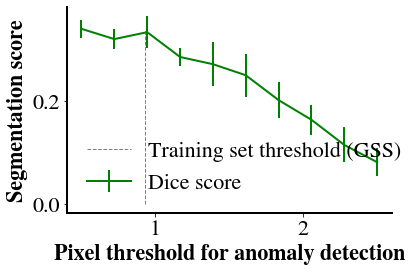

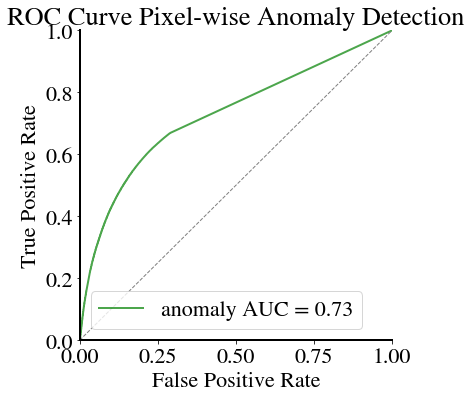

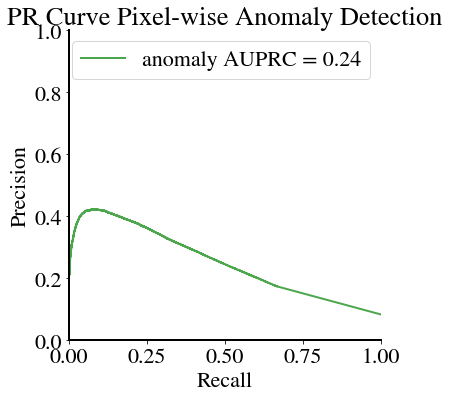

In [7]:
DO_SEGMENTATION      = True
DO_ANOMALY_DETECTION = True
DO_LOSS_HISTOGRAMS   = False
DO_OOD               = False
RESIDUAL_THRESHOLD   = 0.93
DO_PLOTS             = True

eval_cfg = EvaluationConfig()
USE_N_BATCHES = 10
eval_cfg.do_plots = DO_PLOTS
eval_cfg.use_n_batches = USE_N_BATCHES
eval_cfg.ood_config.metrics = ('waic', 'dose')  # 'dose'
eval_cfg.ood_config.dose_statistics = ('rec_err', 'elbo')  # 'entropy, 'kl_div','

results = {}
counter = 0
for name, dataloader  in dataloader_dict.items():
    LOG.info(f'Running evaluation on {name}!')
    result = run_evaluation_pipeline(model, 
                                     camcan_train_dataloader, 
                                     'CamCAN T2',
                                     dataloader,
                                     name,
                                     eval_cfg, 
                                     RESIDUAL_THRESHOLD,
                                     run_segmentation=DO_SEGMENTATION, 
                                     run_anomaly_detection=DO_ANOMALY_DETECTION, 
                                     run_loss_histograms=DO_LOSS_HISTOGRAMS,
                                     run_ood_detection=DO_OOD,
                                     ensemble_models=ensemble_models)
    results[name] = result
    counter += 1
    if counter == 2:
        pass
    

for name, result in results.items():
    print(f'\n\t{name}')
    print_results(result)      